<a href="https://colab.research.google.com/github/ayushm-agrawal/Federated-Learning-Implementations/blob/master/FederatedAveraging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary


# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Sat Jul 25 09:47:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load the MNIST Dataset

In [2]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw





Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw
Processing...
Done!


In [3]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [4]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


## Visualize Data

In [5]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [6]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)


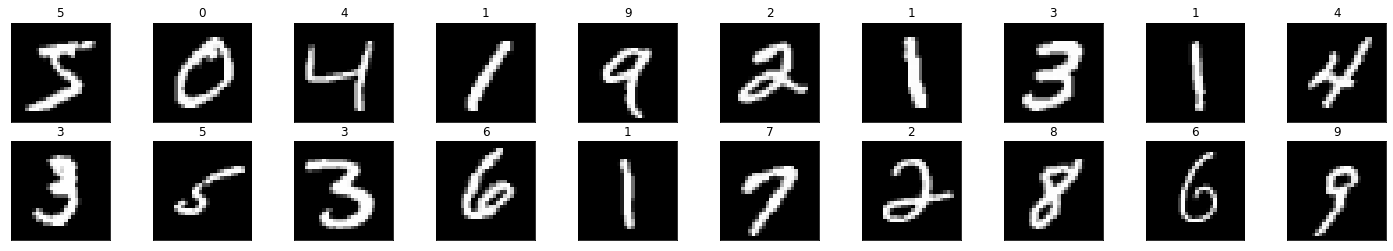

In [7]:
visualize(mnist_data_train)

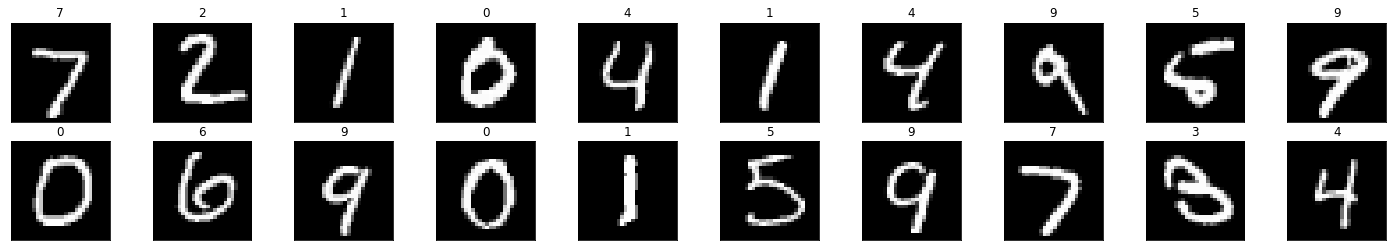

In [8]:
visualize(mnist_data_test)

## Partitioning the Data (IID and non-IID)

In [9]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [10]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict





## Models

In [11]:
class MNIST_2NN(nn.Module):
  """
  A simple multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return x

In [12]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

### Print Model Summaries

In [13]:
mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_mlp.cuda()
  mnist_cnn.cuda()

print("MNIST MLP SUMMARY")
print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))

MNIST MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
None

MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264

## Federated Averaging

### Local Training (Client Update)

Local training for the model on client side

In [14]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

### Server Side Training

Following Algorithm 1 from the paper

In [15]:
def training(model, rounds, batch_size, lr, ds, data_dict, C, K, E, plt_title, plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []
  
  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss = [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[k])
      weights, loss = local_update.train(model=copy.deepcopy(model))

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

  end = time.time()
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model

## Testing Loop

In [16]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # print test accuracy
  for i in range(10):
    if total_class[i]>0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i])))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))

## MNIST CNN on IID

### Train


Round: 1... 	Average Loss: 0.818
Round: 2... 	Average Loss: 0.202
Round: 3... 	Average Loss: 0.139
Round: 4... 	Average Loss: 0.099
Round: 5... 	Average Loss: 0.073
Round: 6... 	Average Loss: 0.066
Round: 7... 	Average Loss: 0.057
Round: 8... 	Average Loss: 0.058
Round: 9... 	Average Loss: 0.052
Round: 10... 	Average Loss: 0.04
Round: 11... 	Average Loss: 0.041
Round: 12... 	Average Loss: 0.04
Round: 13... 	Average Loss: 0.031
Round: 14... 	Average Loss: 0.042
Round: 15... 	Average Loss: 0.032
Round: 16... 	Average Loss: 0.031
Round: 17... 	Average Loss: 0.032
Round: 18... 	Average Loss: 0.029
Round: 19... 	Average Loss: 0.024
Round: 20... 	Average Loss: 0.026
Round: 21... 	Average Loss: 0.027
Round: 22... 	Average Loss: 0.027
Round: 23... 	Average Loss: 0.021
Round: 24... 	Average Loss: 0.024
Round: 25... 	Average Loss: 0.023
Round: 26... 	Average Loss: 0.023
Round: 27... 	Average Loss: 0.024
Round: 28... 	Average Loss: 0.019
Round: 29... 	Average Loss: 0.022
Round: 30... 	Average Los

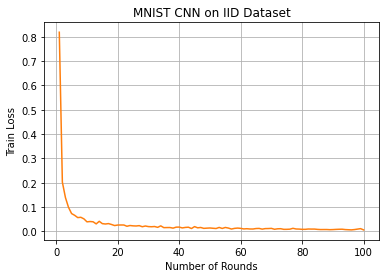

In [17]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.01
# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, C, K, E, "MNIST CNN on IID Dataset", "orange")

### Test

In [18]:
criterion = nn.CrossEntropyLoss()
testing(mnist_cnn_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 0.022679

Test Accuracy of     0: 100% (76/76)
Test Accuracy of     1: 100% (90/90)
Test Accuracy of     2: 100% (91/91)
Test Accuracy of     3: 97% (71/73)
Test Accuracy of     4: 100% (89/89)
Test Accuracy of     5: 98% (67/68)
Test Accuracy of     6: 100% (62/62)
Test Accuracy of     7: 100% (81/81)
Test Accuracy of     8: 100% (77/77)
Test Accuracy of     9: 98% (82/83)

Final Test  Accuracy: 99.494 (786.0/790.0)


## MNIST CNN on Non IID

### Train


Round: 1... 	Average Loss: 0.097
Round: 2... 	Average Loss: 0.048
Round: 3... 	Average Loss: 0.058
Round: 4... 	Average Loss: 0.057
Round: 5... 	Average Loss: 0.031
Round: 6... 	Average Loss: 0.03
Round: 7... 	Average Loss: 0.036
Round: 8... 	Average Loss: 0.017
Round: 9... 	Average Loss: 0.021
Round: 10... 	Average Loss: 0.021
Round: 11... 	Average Loss: 0.027
Round: 12... 	Average Loss: 0.02
Round: 13... 	Average Loss: 0.019
Round: 14... 	Average Loss: 0.023
Round: 15... 	Average Loss: 0.028
Round: 16... 	Average Loss: 0.021
Round: 17... 	Average Loss: 0.012
Round: 18... 	Average Loss: 0.016
Round: 19... 	Average Loss: 0.008
Round: 20... 	Average Loss: 0.017
Round: 21... 	Average Loss: 0.013
Round: 22... 	Average Loss: 0.01
Round: 23... 	Average Loss: 0.01
Round: 24... 	Average Loss: 0.014
Round: 25... 	Average Loss: 0.014
Round: 26... 	Average Loss: 0.013
Round: 27... 	Average Loss: 0.01
Round: 28... 	Average Loss: 0.005
Round: 29... 	Average Loss: 0.012
Round: 30... 	Average Loss: 

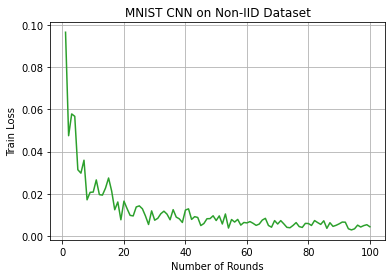

In [19]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.01
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, data_dict, C, K, E, "MNIST CNN on Non-IID Dataset", "green")


### Test

In [20]:
criterion = nn.CrossEntropyLoss()
testing(mnist_cnn_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 0.058476

Test Accuracy of     0: 100% (76/76)
Test Accuracy of     1: 100% (90/90)
Test Accuracy of     2: 98% (90/91)
Test Accuracy of     3: 97% (71/73)
Test Accuracy of     4: 100% (89/89)
Test Accuracy of     5: 97% (66/68)
Test Accuracy of     6: 98% (61/62)
Test Accuracy of     7: 100% (81/81)
Test Accuracy of     8: 96% (74/77)
Test Accuracy of     9: 98% (82/83)

Final Test  Accuracy: 98.734 (780.0/790.0)


## MNIST MLP on IID

### Train

Round: 1... 	Average Loss: 0.607
Round: 2... 	Average Loss: 0.166
Round: 3... 	Average Loss: 0.135
Round: 4... 	Average Loss: 0.106
Round: 5... 	Average Loss: 0.091
Round: 6... 	Average Loss: 0.078
Round: 7... 	Average Loss: 0.072
Round: 8... 	Average Loss: 0.074
Round: 9... 	Average Loss: 0.06
Round: 10... 	Average Loss: 0.059
Round: 11... 	Average Loss: 0.053
Round: 12... 	Average Loss: 0.047
Round: 13... 	Average Loss: 0.049
Round: 14... 	Average Loss: 0.048
Round: 15... 	Average Loss: 0.048
Round: 16... 	Average Loss: 0.046
Round: 17... 	Average Loss: 0.039
Round: 18... 	Average Loss: 0.041
Round: 19... 	Average Loss: 0.041
Round: 20... 	Average Loss: 0.032
Round: 21... 	Average Loss: 0.031
Round: 22... 	Average Loss: 0.029
Round: 23... 	Average Loss: 0.034
Round: 24... 	Average Loss: 0.035
Round: 25... 	Average Loss: 0.027
Round: 26... 	Average Loss: 0.03
Round: 27... 	Average Loss: 0.032
Round: 28... 	Average Loss: 0.023
Round: 29... 	Average Loss: 0.032
Round: 30... 	Average Los

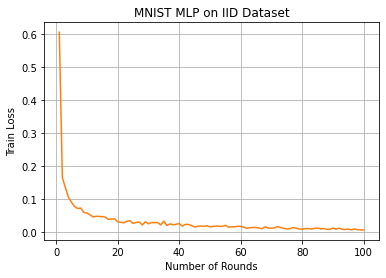

In [21]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each round
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.03
# dict containing different type of data partition
data_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, C, K, E, "MNIST MLP on IID Dataset", "orange")


### Test

In [22]:
criterion = nn.CrossEntropyLoss()
testing(mnist_mlp_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 0.071607

Test Accuracy of     0: 97% (74/76)
Test Accuracy of     1: 97% (88/90)
Test Accuracy of     2: 98% (90/91)
Test Accuracy of     3: 97% (71/73)
Test Accuracy of     4: 96% (86/89)
Test Accuracy of     5: 98% (67/68)
Test Accuracy of     6: 96% (60/62)
Test Accuracy of     7: 98% (80/81)
Test Accuracy of     8: 98% (76/77)
Test Accuracy of     9: 97% (81/83)

Final Test  Accuracy: 97.848 (773.0/790.0)


## MNIST MLP on Non IID

### Train

Round: 1... 	Average Loss: 0.125
Round: 2... 	Average Loss: 0.081
Round: 3... 	Average Loss: 0.036
Round: 4... 	Average Loss: 0.024
Round: 5... 	Average Loss: 0.021
Round: 6... 	Average Loss: 0.036
Round: 7... 	Average Loss: 0.02
Round: 8... 	Average Loss: 0.014
Round: 9... 	Average Loss: 0.018
Round: 10... 	Average Loss: 0.022
Round: 11... 	Average Loss: 0.023
Round: 12... 	Average Loss: 0.041
Round: 13... 	Average Loss: 0.026
Round: 14... 	Average Loss: 0.016
Round: 15... 	Average Loss: 0.019
Round: 16... 	Average Loss: 0.012
Round: 17... 	Average Loss: 0.035
Round: 18... 	Average Loss: 0.018
Round: 19... 	Average Loss: 0.02
Round: 20... 	Average Loss: 0.013
Round: 21... 	Average Loss: 0.012
Round: 22... 	Average Loss: 0.019
Round: 23... 	Average Loss: 0.019
Round: 24... 	Average Loss: 0.015
Round: 25... 	Average Loss: 0.022
Round: 26... 	Average Loss: 0.02
Round: 27... 	Average Loss: 0.016
Round: 28... 	Average Loss: 0.019
Round: 29... 	Average Loss: 0.025
Round: 30... 	Average Loss

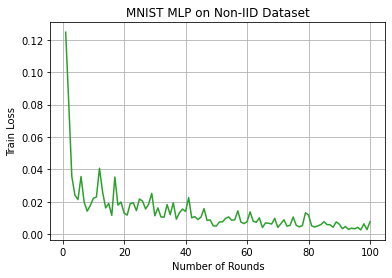

In [23]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.05
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_non_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, C, K, E, "MNIST MLP on Non-IID Dataset", "green")

### Test

In [24]:
criterion = nn.CrossEntropyLoss()
testing(mnist_mlp_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 0.156672

Test Accuracy of     0: 98% (75/76)
Test Accuracy of     1: 96% (87/90)
Test Accuracy of     2: 92% (84/91)
Test Accuracy of     3: 100% (73/73)
Test Accuracy of     4: 97% (87/89)
Test Accuracy of     5: 97% (66/68)
Test Accuracy of     6: 98% (61/62)
Test Accuracy of     7: 90% (73/81)
Test Accuracy of     8: 85% (66/77)
Test Accuracy of     9: 91% (76/83)

Final Test  Accuracy: 94.684 (748.0/790.0)


# Summary of Experiments and Results

I ran 4 different experiments for the Federated Averaging Paper (Linked -> [here](https://arxiv.org/pdf/1602.05629.pdf)). 

You can look at the training graph with the training for each experiment above.
 
    **MNIST CNN**

      - IID Parition: (Test Accuracy 99.434%)
      - non-IID Parition: (Test Accuracy 98.734%)

    **MNIST MLP**
      - IID Parition: (Test Accuracy 97.848%)
      - non-IID Parition: (Tes0t Accuracy 94.684%)

---

### Observations

#### Model Architecture

The first thing that I observed here was, in the paper for the CNN architecture, the authors have reported that total parameters as **1,663,370**. After my implementation, the total parameters that I got were **582,026**

Authors, haven't used Dropout layers but I noticed a significant improvement in training with a single dropout layer after the second CNN layer with a drop probability of **0.2**.

#### Hyperparameters

Authors have reported the following hyperparameters for their CNN model 

    IID Partition
      - Learning Rate: 0.215
      - Local Epochs: 1, 5, 25, 50, 100, 200, 400
      - Local Batch Size: 10
      - Client Fraction: 0.1
      - Optimizer: SGD

    non-IID Partition
        - Learning Rate: 0.1
        - Local Epochs: 1, 5, 25, 50, 100, 200, 400
        - Local Batch Size: 10
        - Client Fraction: 0.1
        - Optimizer: SGD

I noted that, using the following hyperparameters, my network gets stuck in a local minima and doesn't converge. The learning rate used by the authors seems to be very high for deep learning task

*The hyperparameters that worked for me on CNN are the following*

    - Learning Rate: 0.01
    - Local Epochs: 5
    - Local Batch Size: 10
    - Client Fraction: 0.1
    - Optimizer: SGD


For CNN trained on non-IID data partition, with my hyperparameters, the test accuracy can be achieved with just 50 rounds of communication instead of 100.


For, MLP model, I noticed that with learning rate of **0.01**, the network was getting stuck in a local minima. I experimented with **0.03** and **0.05** learning rate that gave me better results on the MLP model
---

**Big thanks to https://github.com/SarodYatawatta/federated-pytorch-test for providing an easy to understand implementation of federated learning to get me started in this field.**